In [1]:
# ---------- Graphics ------------
# matplotlib
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=0.5,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)

%matplotlib inline
#%matplotlib osx
#%matplotlib nbagg
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
#rcParams["text.usetex"] = True #uncomment to use tex. Slow, but pretty
#rcParams["font.weight"] = 900

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=4
rcParams['xtick.minor.width']=0.5
rcParams['xtick.minor.size']=2
rcParams['xtick.direction'] = "in"
rcParams['ytick.direction'] = "in"
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=4
rcParams['ytick.minor.width']=0.5
rcParams['ytick.minor.size']=2

In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=0.5,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")

In [3]:
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils
utils.norm_mean

<function utils.<lambda>>

# Read in data

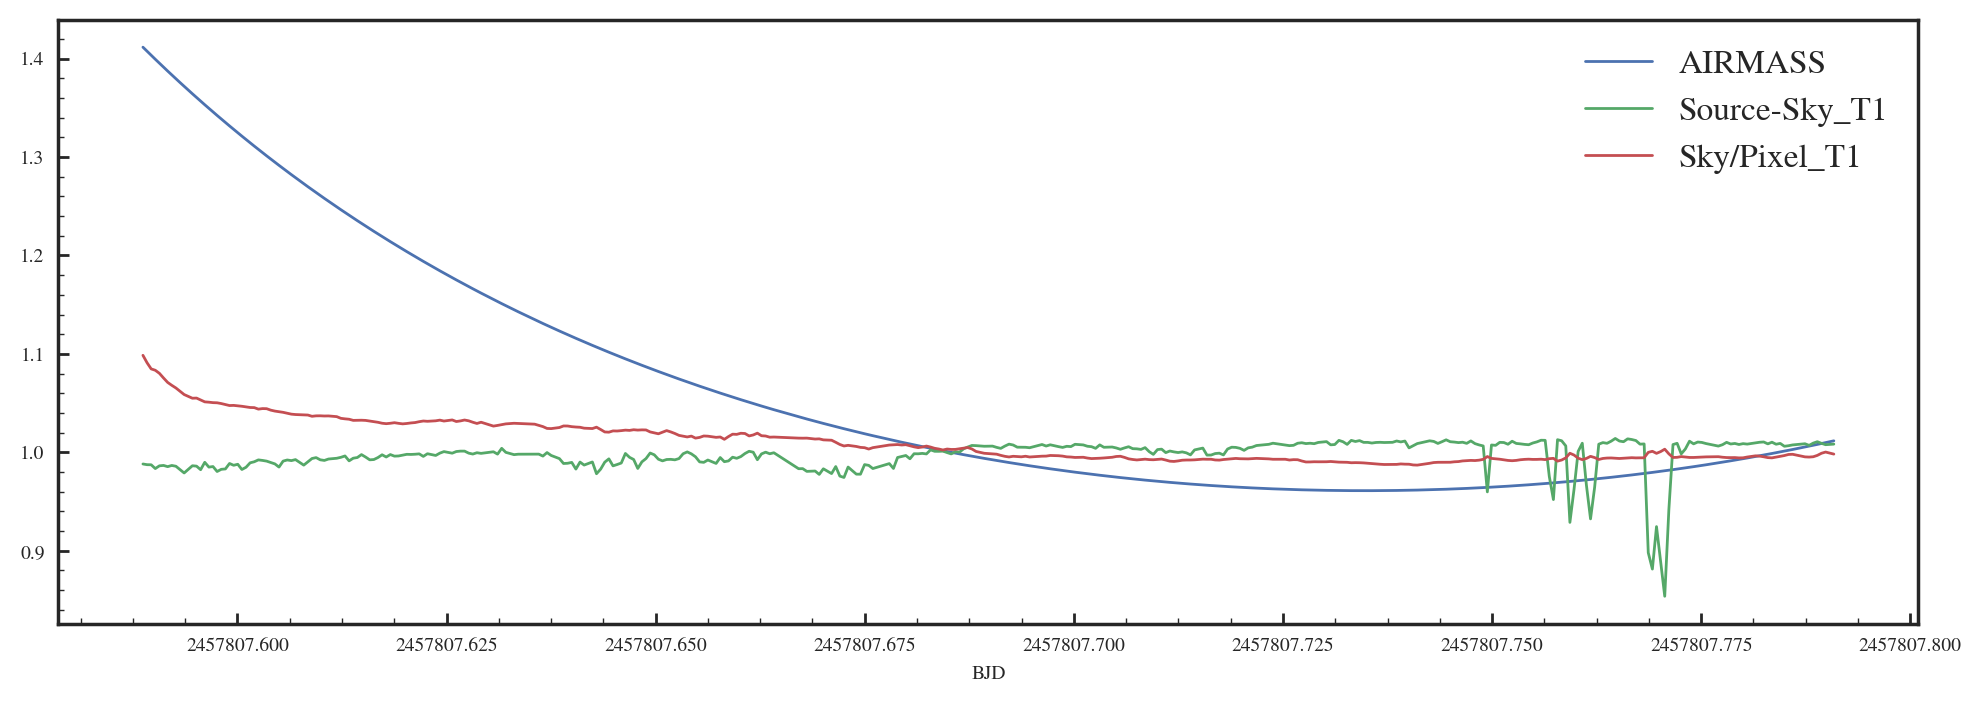

In [4]:
df_ground = pd.read_csv("../data/k2_104b/Processed_k2104b_fast_quad_4x4_1129_12_21_40_measurements.xls",sep="\t")
# Take out bad sky points
df_ground = df_ground[0:-20]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground.AIRMASS))
ax.plot(df_ground.BJD_TDB,utils.norm_median(df_ground["Source-Sky_T1"]))
ax.plot(df_ground.BJD_TDB,((utils.norm_median(df_ground["Sky/Pixel_T1"])-1)*0.1)+1.)

ax.set_xlabel("BJD")
ax.legend(loc="upper right",fontsize=12)
ax.minorticks_on()

# Calculate scintillation errorbars

In [5]:
# Define variables
t_ground = df_ground.BJD_TDB.values
f_ground = df_ground.rel_flux_T1.values#/np.nanmedian(df_ground.rel_flux_T1.values)
err_ground = df_ground.rel_flux_err_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)

# Other params
NREFSTARS = 5.
cadence = np.median(np.diff(t_ground))*24.*60.*60.
print("Cadence {}s".format(cadence))

# Calculate the mean values for scintillation and photon to plot on the plot
final_unbinned_scint_noise = utils.scintillation_noise(350.,np.mean(df_ground["AIRMASS"]),cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
final_unbinned_phot_noise = np.mean(df_ground.rel_flux_err_T1)
print("Mean photon error: {}".format(final_unbinned_phot_noise))
print("Mean scint error: {}".format(final_unbinned_scint_noise))

# Calculate full array of errors including scintilation
scint_error = utils.scintillation_noise(350.,df_ground.AIRMASS.values,cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
tot_error = np.sqrt(scint_error**2.+err_ground**2.)

Cadence 42.5952024758s
Mean photon error: 0.00053964109589
Mean scint error: 0.000287304753187


### Plotting with scintillation errorbars

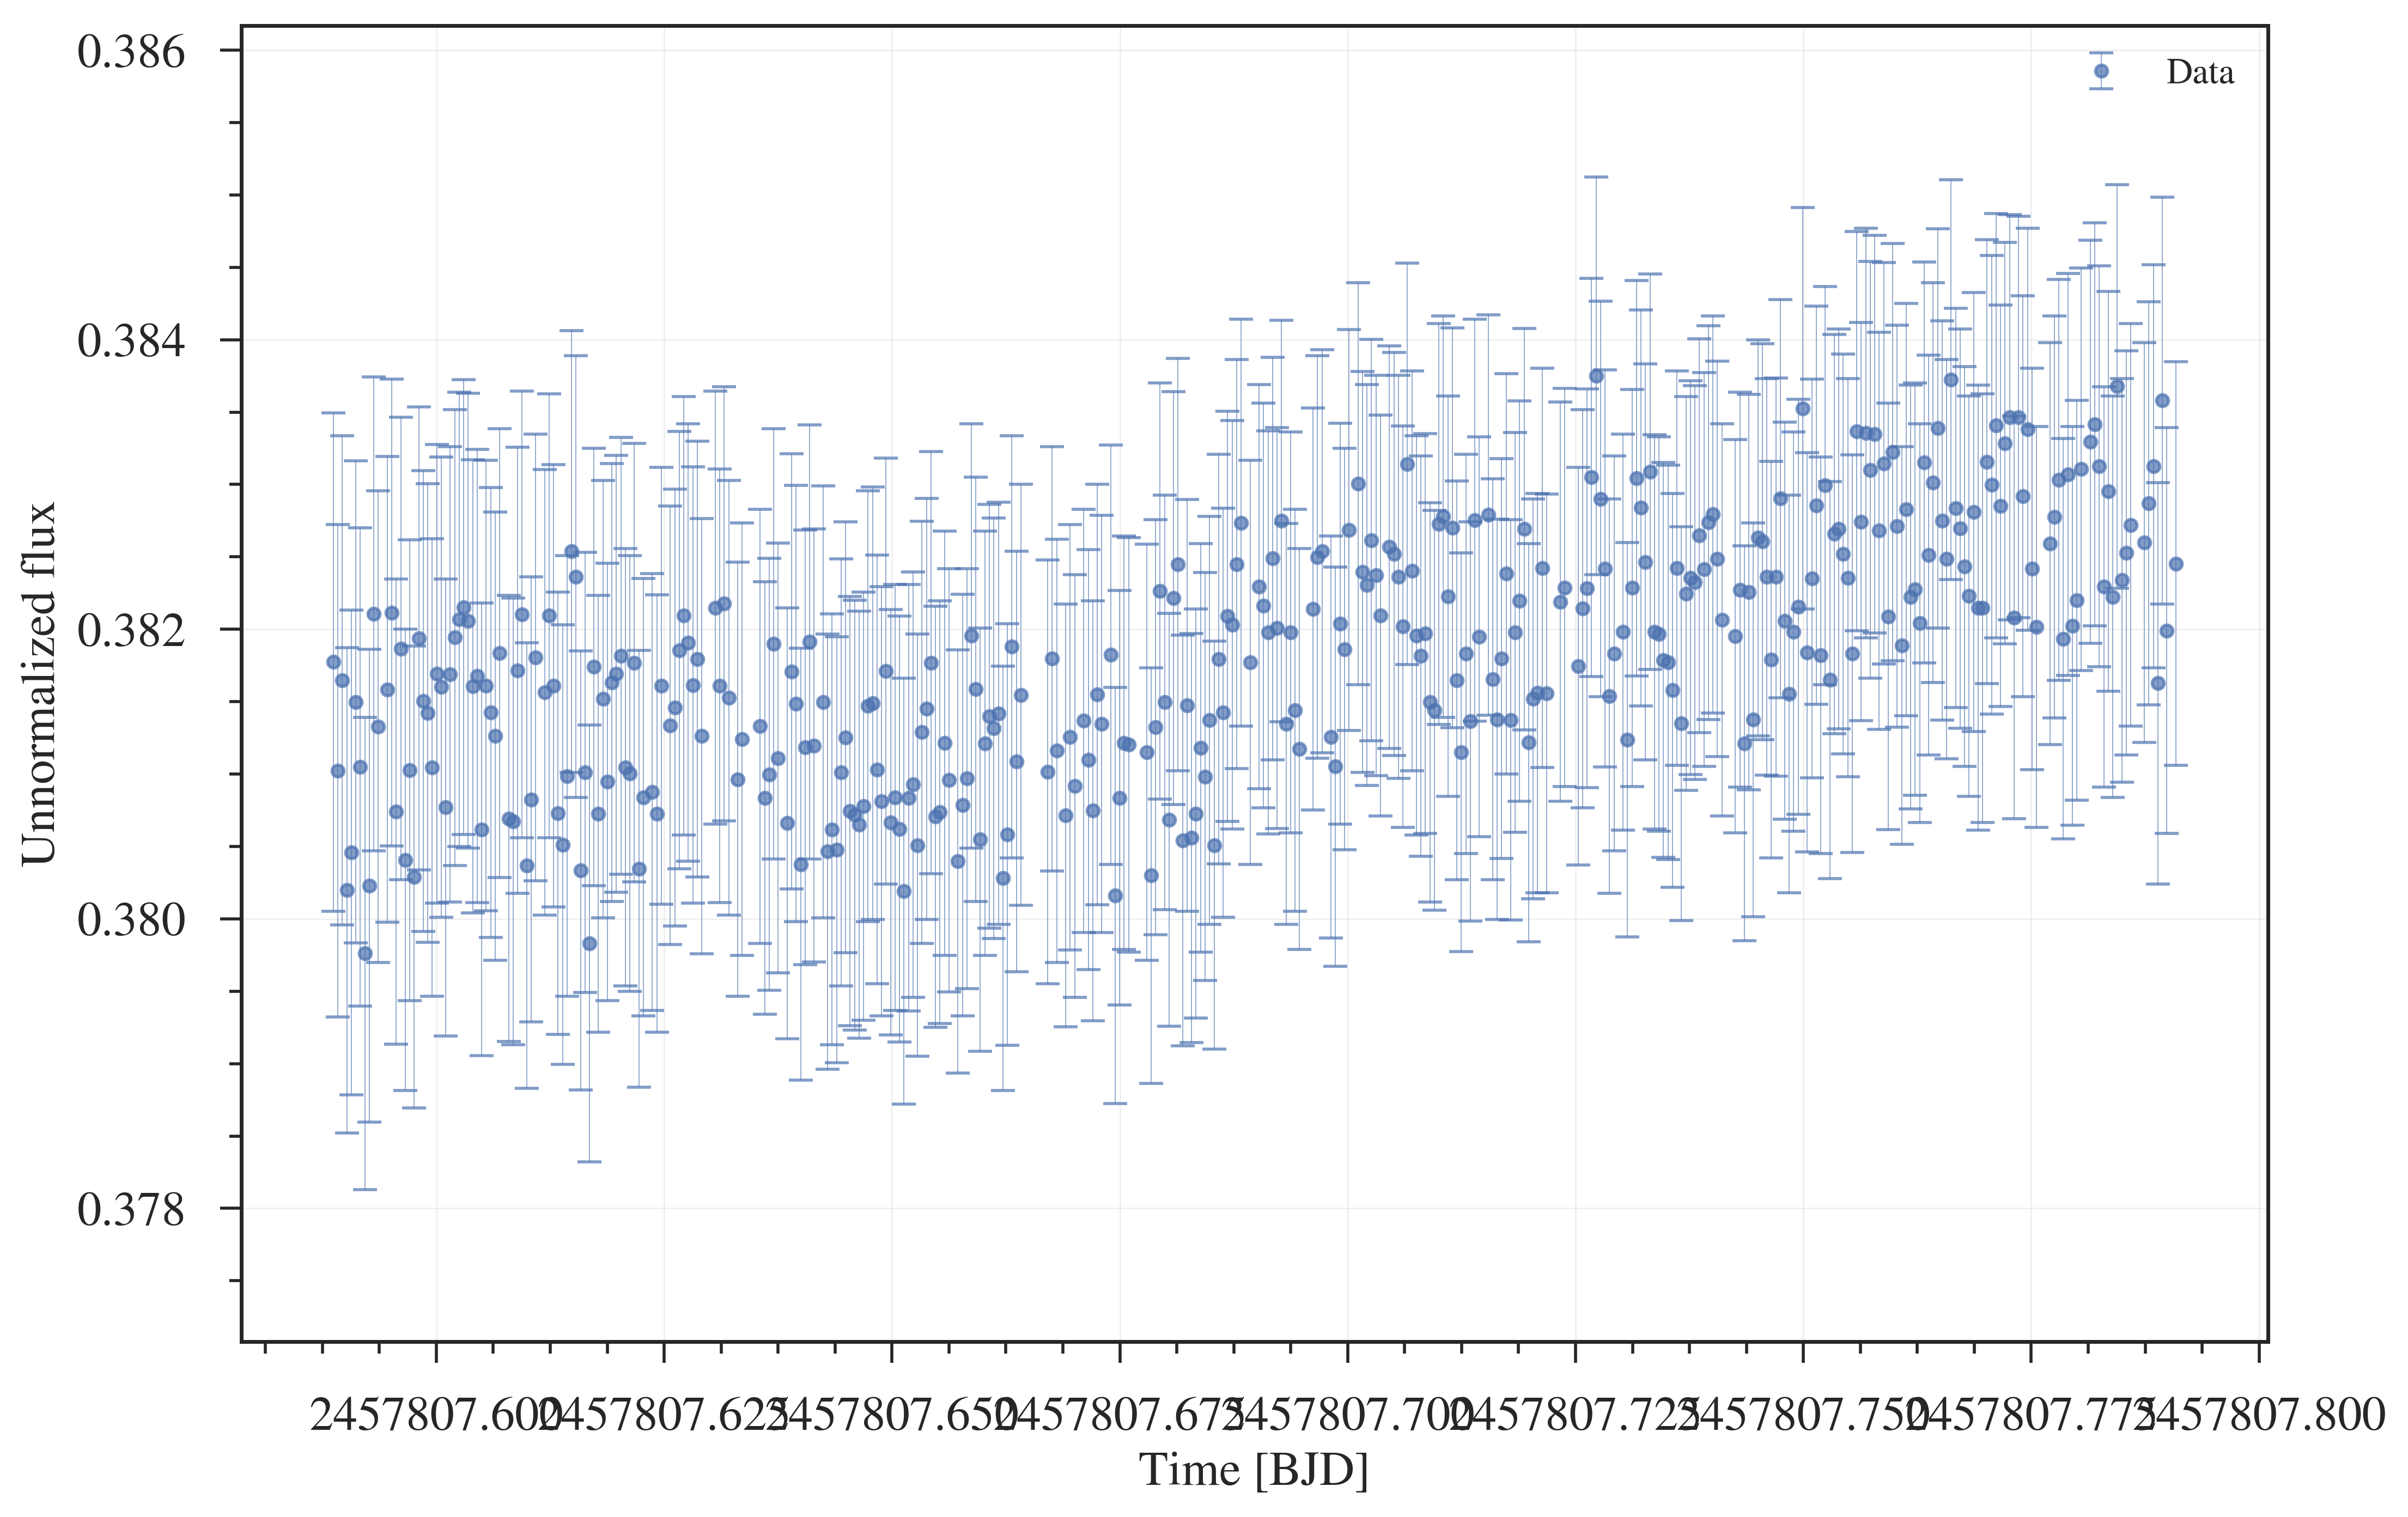

In [7]:
import plot_transits
fig, ax = plt.subplots(figsize=(12,8))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
#ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
#ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
#ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
#ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=16)
ax.set_ylabel("Unnormalized flux",fontsize=16)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=12)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=16)

In [6]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    
    #def __init__(self):

        # This is only performed during initialization
        #self.data= {"time"   : dfmm_s.time.values,  # phase folded time in days (centered on 0)
        #            "flux"   : dfmm_s.y.values   # phase folded flux
        #            }
        
    def __init__(self,number_pv_baseline=5,convergence_diagnostics=False):
        # This is only performed during initialization
        self.convergence_diagnostics = convergence_diagnostics
        self.number_pv_baseline = number_pv_baseline
        #df = df
        df = pd.read_csv("../data/k2_104b/Processed_k2104b_fast_quad_4x4_1129_12_21_40_measurements.xls",sep="\t")
        #df = df[31:130] # exluding some data due to meridian flip
        #meridian = np.ones_like(df.BJD_TDB.values)
        #meridian[31:] = 0.
        self.data= {"time"   : df.BJD_TDB.values,
                    "flux"   : df.rel_flux_T1.values,
                    "error"  : df.rel_flux_err_T1.values,
                    "line"   : (df.BJD_TDB.values-df.BJD_TDB.values[0])/np.nanmean(df.BJD_TDB.values-df.BJD_TDB.values[0]),
                    "airmass": df.AIRMASS.values/np.nanmean(df.AIRMASS.values),
                    "x"      : df["X(FITS)_T1"].values/np.nanmean(df["X(FITS)_T1"].values),
                    "y"      : df["Y(FITS)_T1"].values/np.nanmean(df["Y(FITS)_T1"].values)}
                    #"meridian": meridian}
        
        #####
        # Setting priors
        self.priors = [UP(2457807.6605-0.01    ,2457807.6605+0.01 , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       NP( np.log10(1.974349)  ,0.00007          , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       UP( 0                   ,0.2               , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   2 - cos(i)
                       UP( 0.0                 ,0.05              , 'RpRs'     ,r'$R_p/R_s$'             ,priortype="model"),  ##   3 - rp/rstar
                       UP( 0.9                 ,1.1              , 'log(a/Rs)',r'$\log(a/R_s)$'         ,priortype="model"),  ##   4 - log(a/rstar)     
                       #UP( 0.                 ,1.                , 'q1'       ,r'$q_1$'                 ,priortype="model"),  ##   5 - q1
                       #UP( 0.                 ,1.                , 'q2'       ,r'$q_2$'                 ,priortype="model"),  ##   6 - q2
                       UP( 0.378                ,0.386             , 'fraw'     ,r'fraw'                  ,priortype="baseline"),##  7 - Baseline constant
                       UP( -0.1                ,0.1               , 'line'     ,r'line'                  ,priortype="detrend")] ##  8 - Line
                       #UP( -0.1               , 0.1              , 'airmass'  ,r'airmass'               ,priortype="detrend"),##   9 - Airmass
                       #UP( -0.1               , 0.1              , 'x'        ,r'X'                     ,priortype="detrend")]##   10 - x
                       #UP( -0.1               , 0.1              , 'y'        ,r'Y'                     ,priortype="detrend")]##   11 - y
        
        # If we want to fix limb-dark parameters
        self.limbdark = [0.49457442,0.16680525]#[ 0.16689202, 0.44493439] 
        self.ps     = PriorSet(self.priors)
        self.number_pv_baseline = np.where(np.array(self.ps.priortypes)=="baseline")[0][0]
        print("Baseline is at pv=",self.number_pv_baseline)
        
    def compute_transit(self,pv,times=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        self.params = batman.TransitParams()
        self.params.t0 = pv[0]
        self.params.per = 10.**pv[1]
        self.params.inc = np.arccos(pv[2])*180./math.pi
        self.params.rp = pv[3]
        self.params.a = 10.**pv[4]
        self.params.ecc = 0.
        self.params.w = 0.
        #q1, q2 = pv[5], pv[6]
        #self.params.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params.u = self.limbdark
        self.params.limb_dark = "quadratic"
        self.params.fp = 0.001
        if times is None:
            times = self.data["time"]        
        transitmodel = batman.TransitModel(self.params, times, transittype='primary')#supersample_factor=7,exp_time=0.020431801470066003)
        self.lc = transitmodel.light_curve(self.params)
        return self.lc        
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
        pv    - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            #print(i)
            detrend += pv[i]*(self.data[self.ps.labels[i]]-1.)
        return detrend/pv[self.number_pv_baseline]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
        pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        The full light curve model with a trend
        
        TODO:
        - Choose to use GPs ?
        """
        return self.compute_transit(pv) + self.detrend(pv)
    
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        """
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        scaled_flux   = self.data["flux"]/pv[self.number_pv_baseline]
        #log_of_model  = ll_normal_es(scaled_flux, flux_m, pv[self.number_pv_error])
        log_of_model  = ll_normal_ev(scaled_flux, flux_m, self.data['error'])
        
        log_ln = log_of_priors + log_of_model
        
        return log_ln

In [7]:
import trf
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
TF = trf.TransitFit(LPFunction)

Baseline is at pv= 5


In [8]:
TF.lpf.ps.get_param_type_indices(paramtype="detrend")

[6]

In [12]:
TF.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0         tc  2.457808e+06  2.457808e+06  2.457808e+06  2.457808e+06  7.206309e-04
1       logP  2.954239e-01  2.950739e-01  2.957739e-01  2.954243e-01 -3.351541e-07
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  3.514165e-03  9.648584e-02
3       RpRs  2.500000e-02  0.000000e+00  5.000000e-02  3.856280e-02 -1.356280e-02
4  log(a/Rs)  1.000000e+00  9.000000e-01  1.100000e+00  1.063852e+00 -6.385227e-02
5       fraw  3.820000e-01  3.780000e-01  3.860000e-01  3.820142e-01 -1.419975e-05
6       line  0.000000e+00 -1.000000e-01  1.000000e-01  8.301837e-04 -8.301837e-04
LogLn value: -1160.50707654
Log priors 25.2124480966


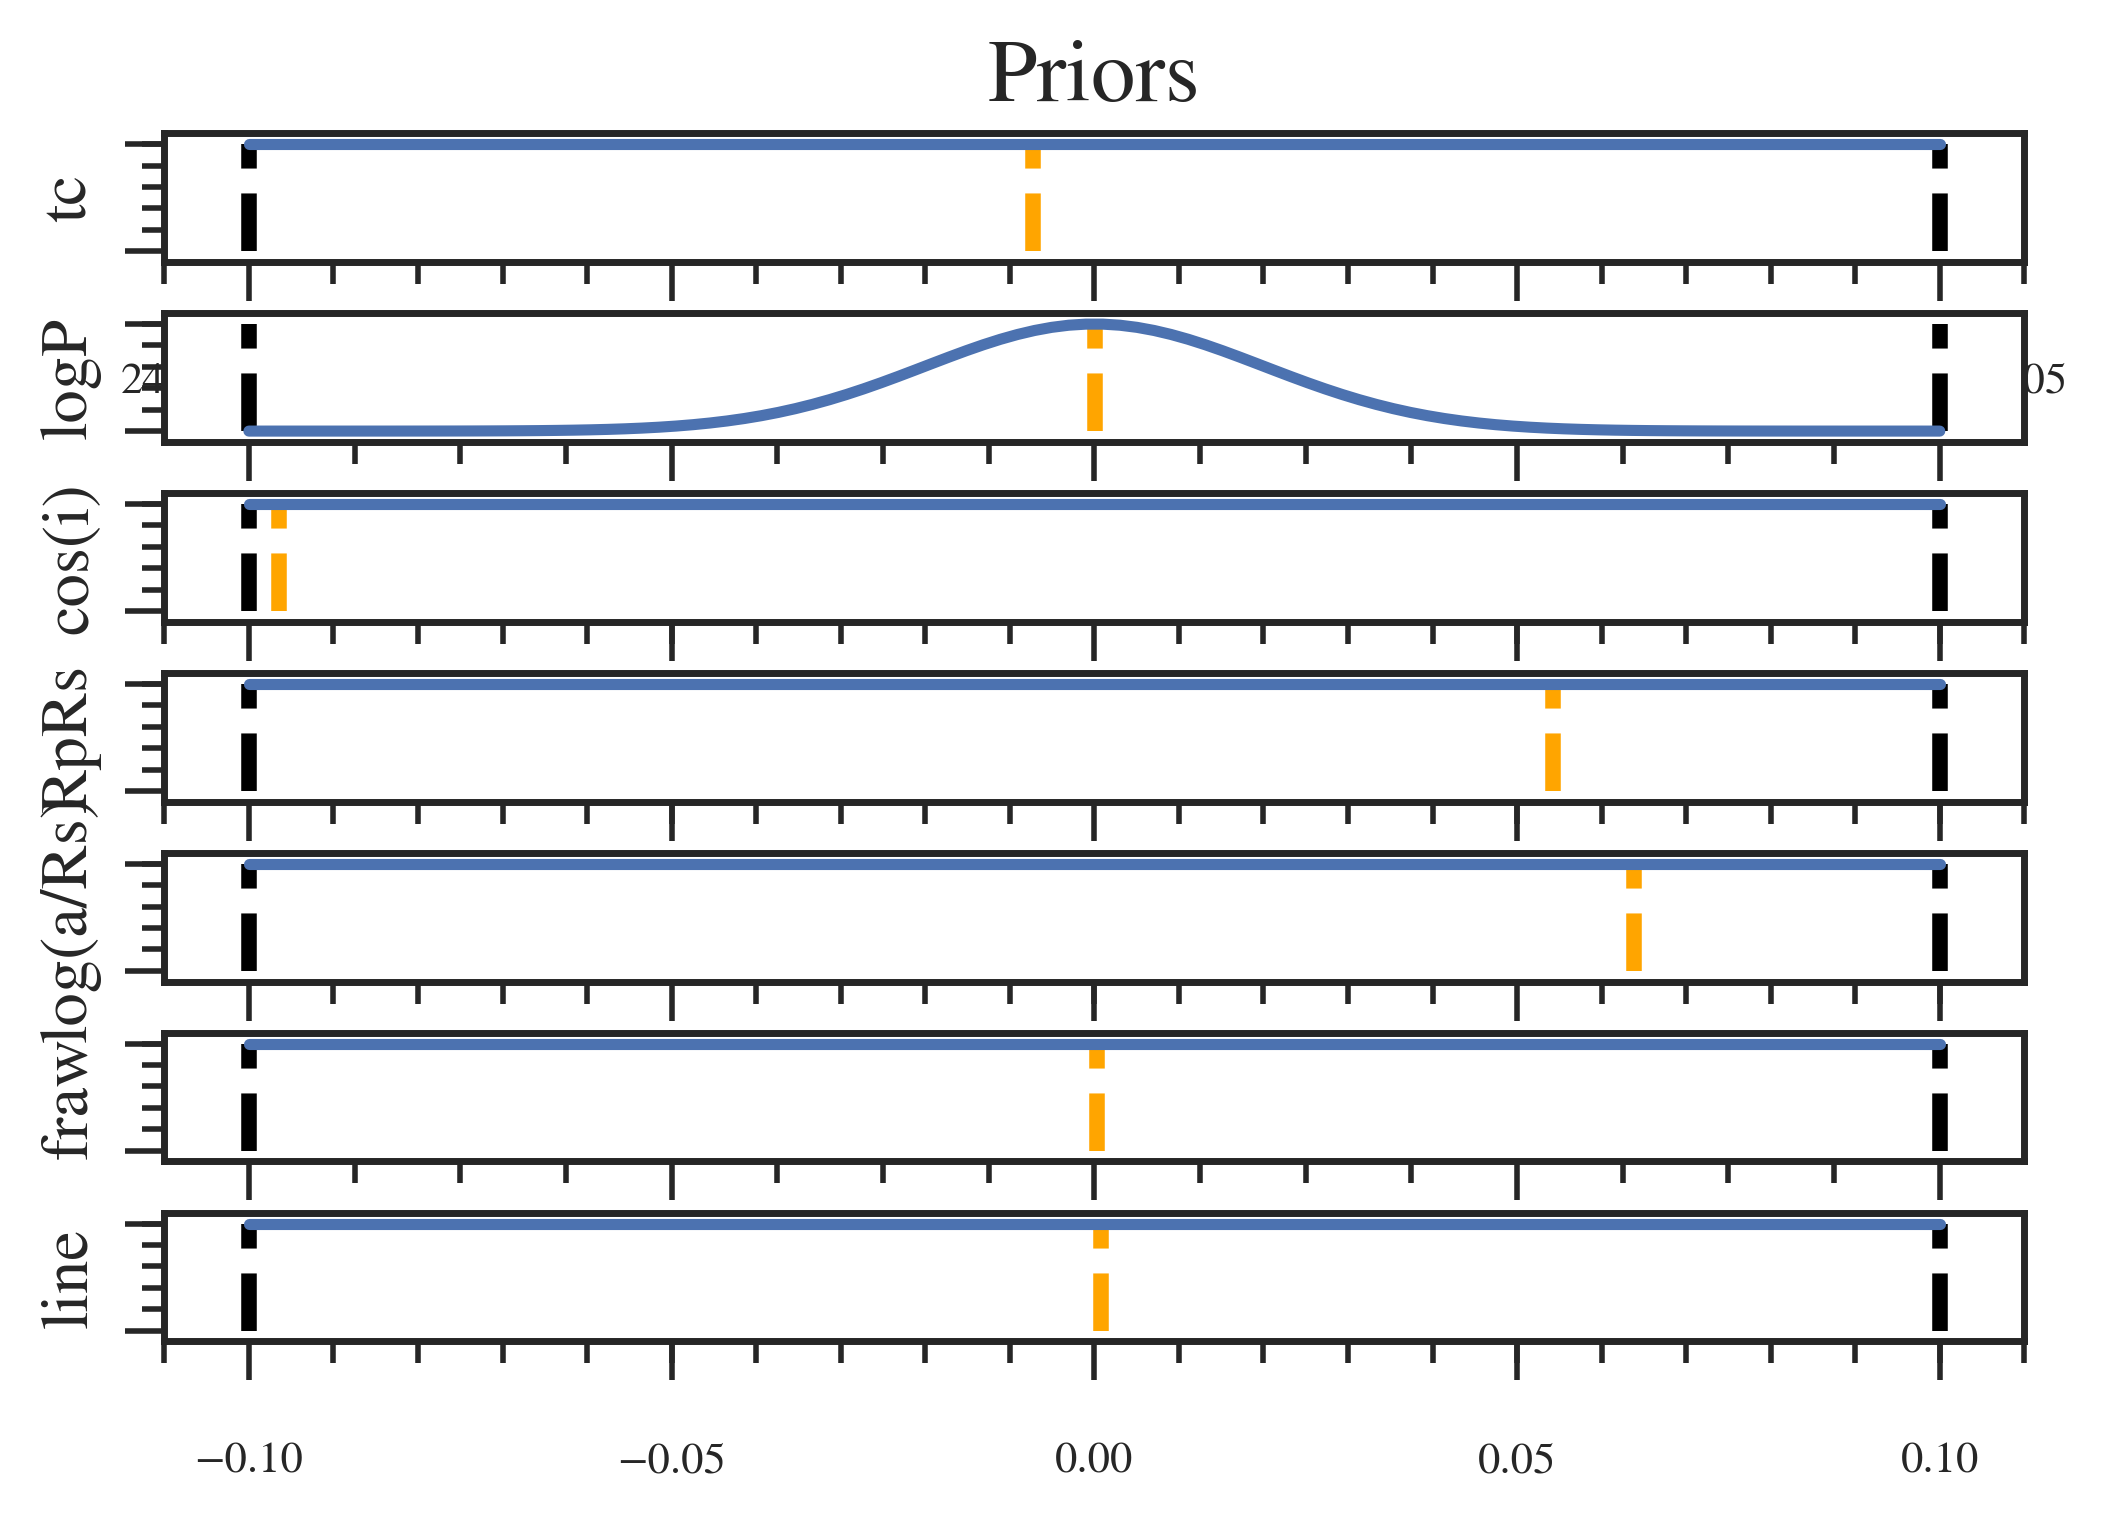

In [13]:
TF.lpf.ps.plot_all(TF.min_pv)

In [14]:
TF.min_pv

array([  2.45780766e+06,   2.95424259e-01,   3.51416493e-03,
         3.85628001e-02,   1.06385227e+00,   3.82014200e-01,
         8.30183745e-04])

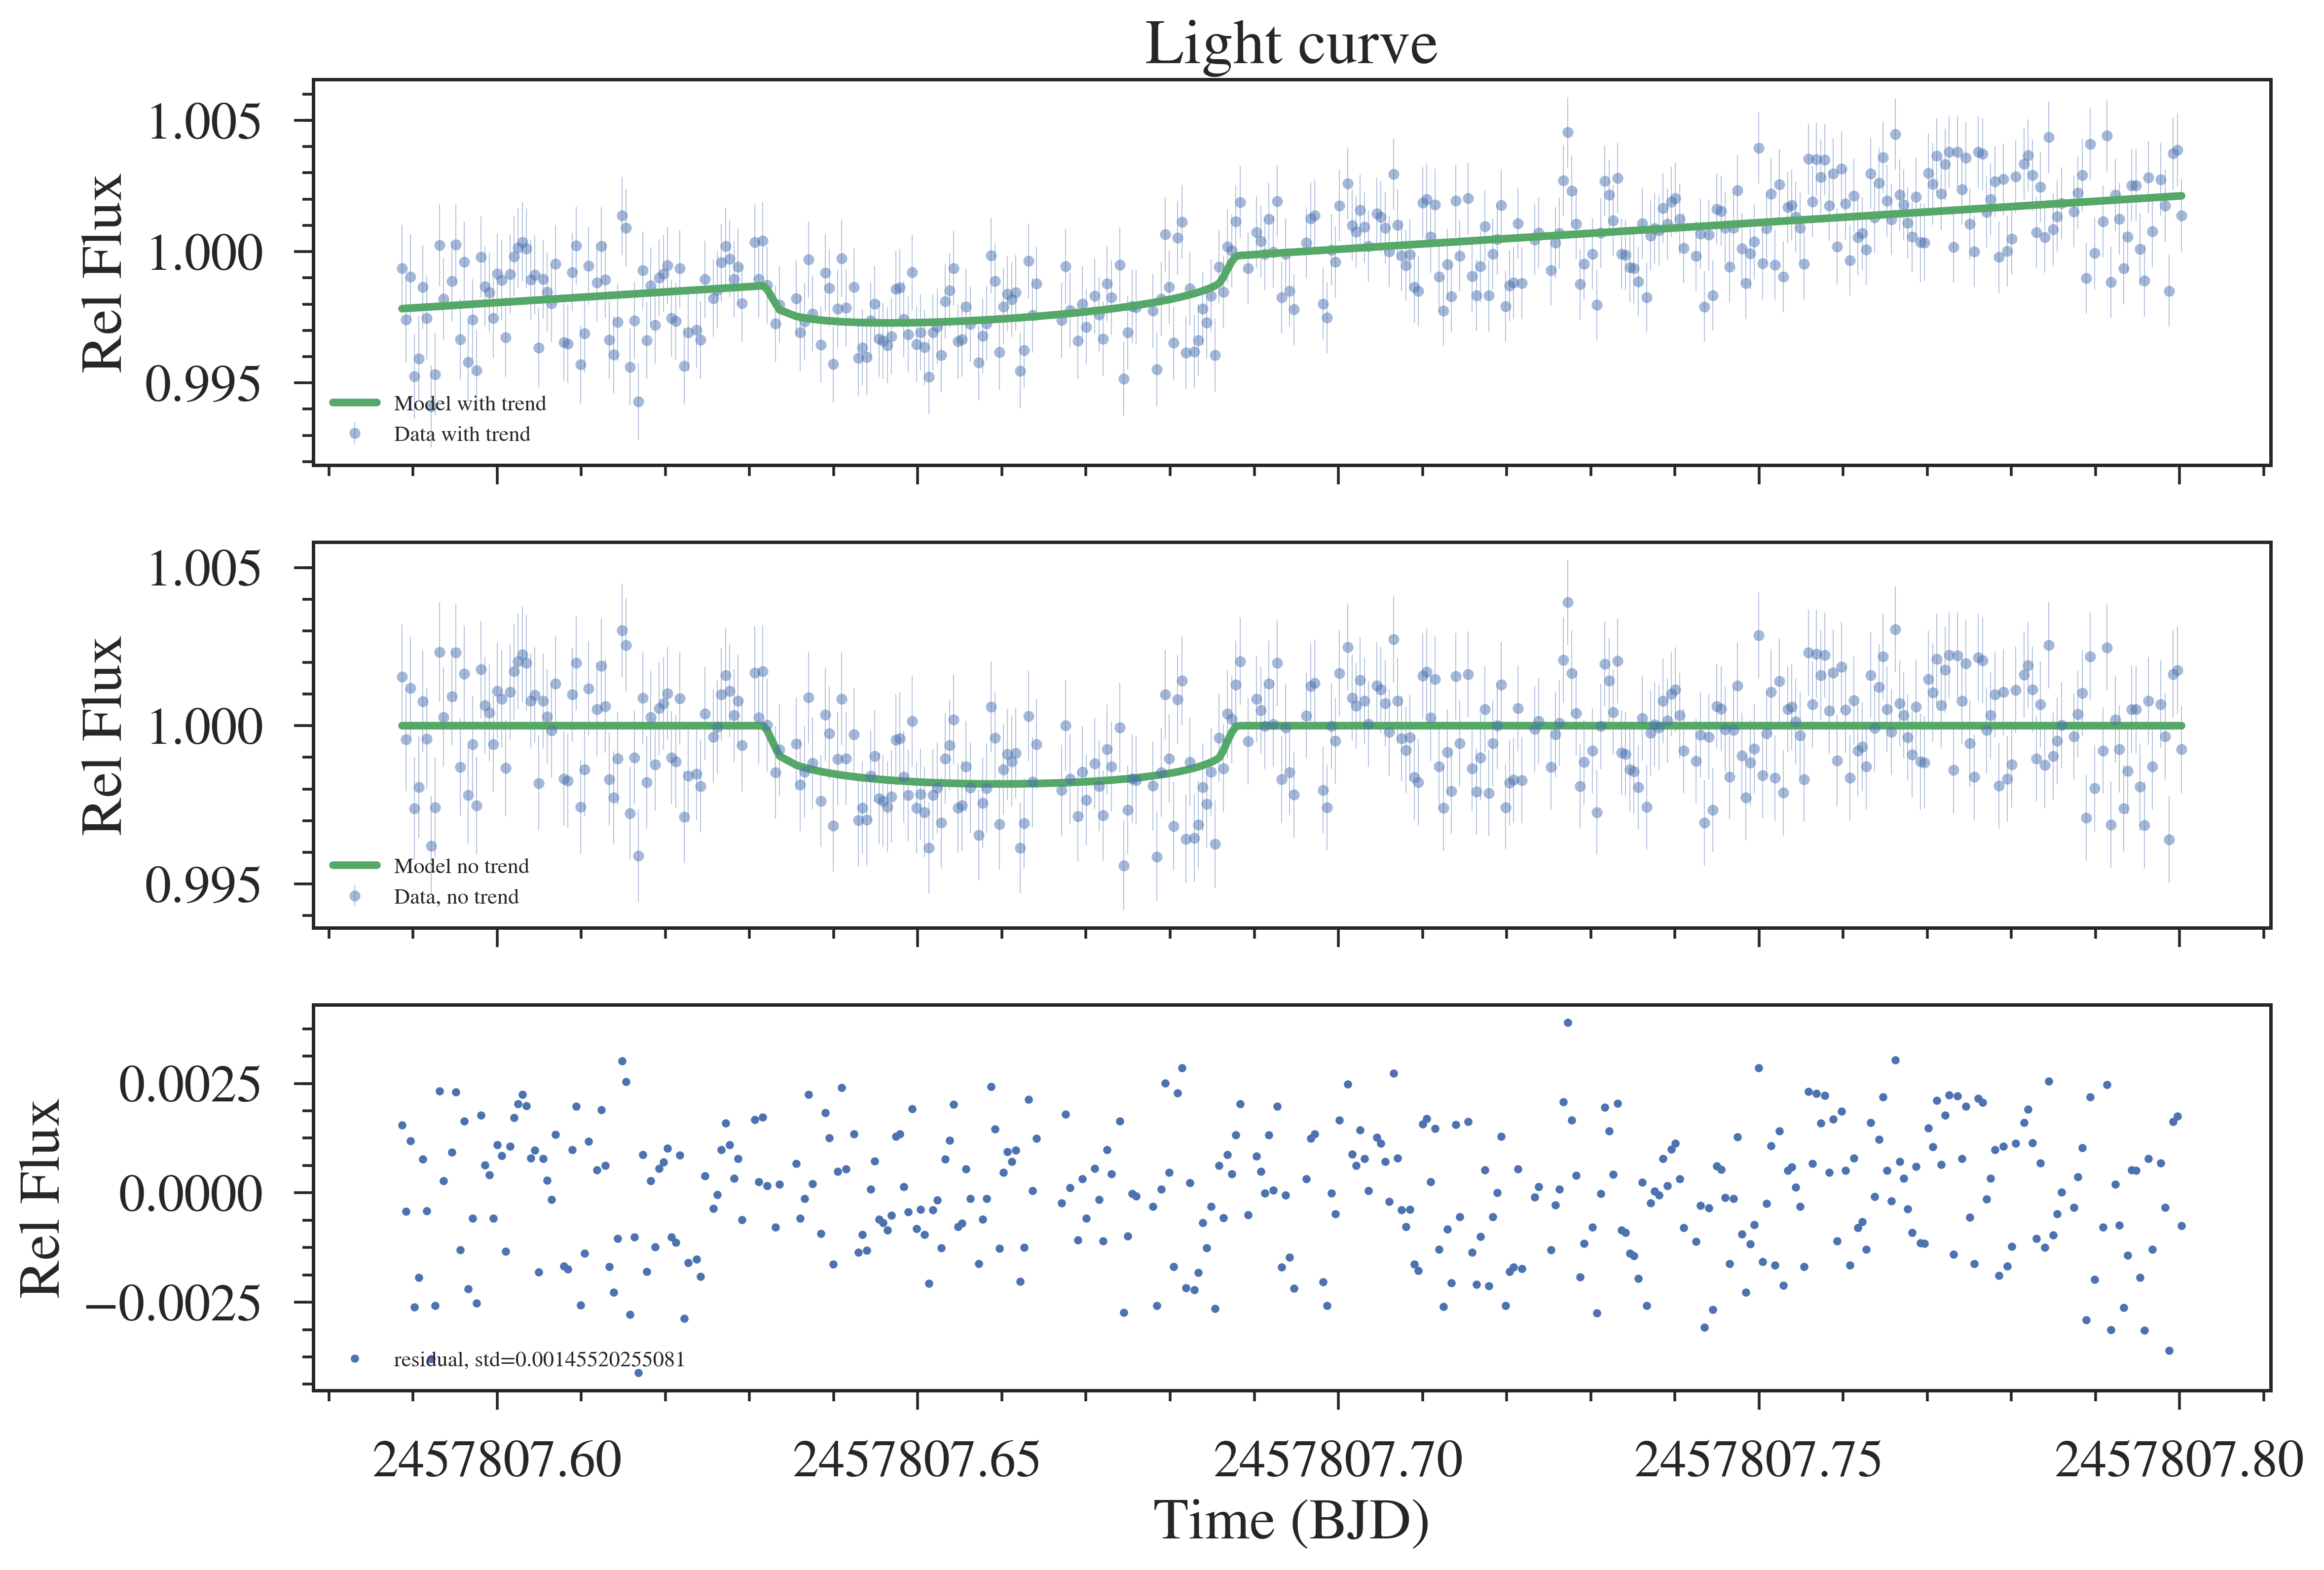

In [15]:
TF.plot_lc_fit()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/Sophie/git/MCcubed/")
#sys.path.append("/Users/gks/programs/MCcubed2/MCcubed") # Add path to mc3 if necessary
import allanvariancemc_modified 
import pandas as pd

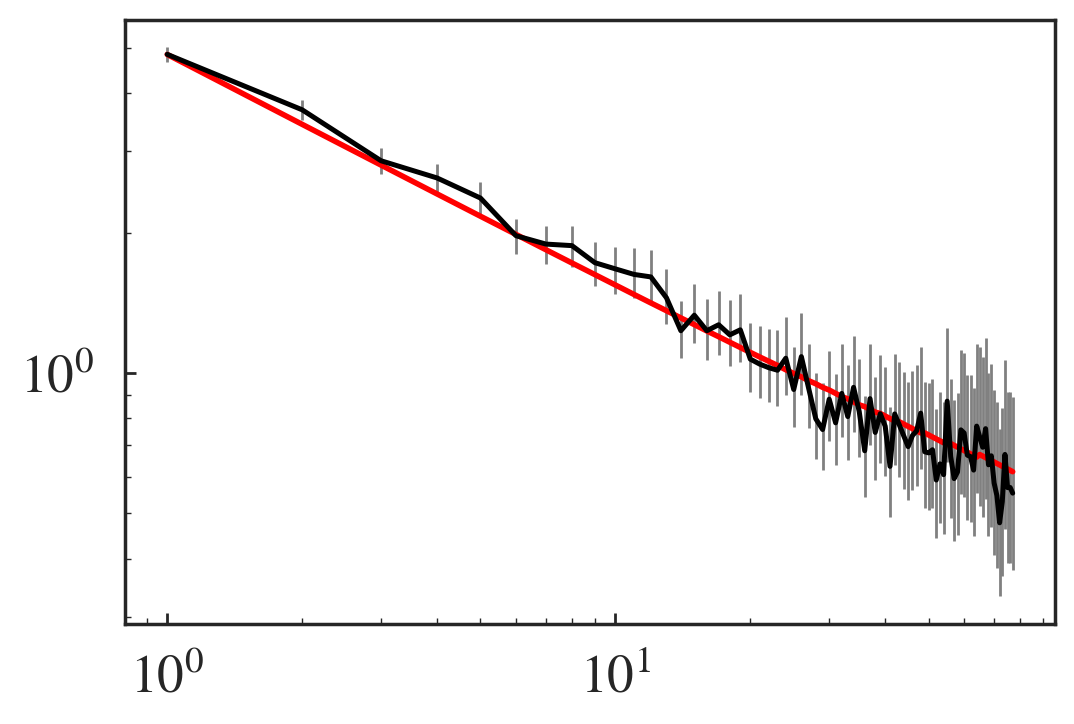

In [17]:
#creating allan variance plot
avmc = allanvariancemc_modified.AllanVarianceMC()
avmc.compute_noise(TF.residual)
fig, ax = avmc.plot()

In [16]:
#binsz
#def plot_allenvariance(x,y,ax=None):
#    if ax is None:
#        fig, ax = plt.subplots()
#    ax.loglog(x,y)
#    
#fig, ax = plt.subplots(nrows=3,ncols=3)
#bx = ax.flatten()[0]
#plot_allenvariance(binsz,rms,ax=bx)
#fig.tight_layout()

In [9]:
TF.minimize_PyDE(mcmc=True,mc_iter=2000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.457808e+06  2.457808e+06  2.457808e+06  2.457808e+06     0.000728
1       logP  2.954239e-01  2.950739e-01  2.957739e-01  2.954254e-01    -0.000001
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  1.995662e-03     0.098004
3       RpRs  2.500000e-02  0.000000e+00  5.000000e-02  3.856285e-02    -0.013563
4  log(a/Rs)  1.000000e+00  9.000000e-01  1.100000e+00  1.064093e+00    -0.064093
5       fraw  3.820000e-01  3.780000e-01  3.860000e-01  3.820142e-01    -0.000014
6       line  0.000000e+00 -1.000000e-01  1.000000e-01  8.305342e-04    -0.000831
LogLn value: -1160.50875531
Log priors 25.2122414749
Running MCMC
MCMC iterations= 2000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

Plotting chains


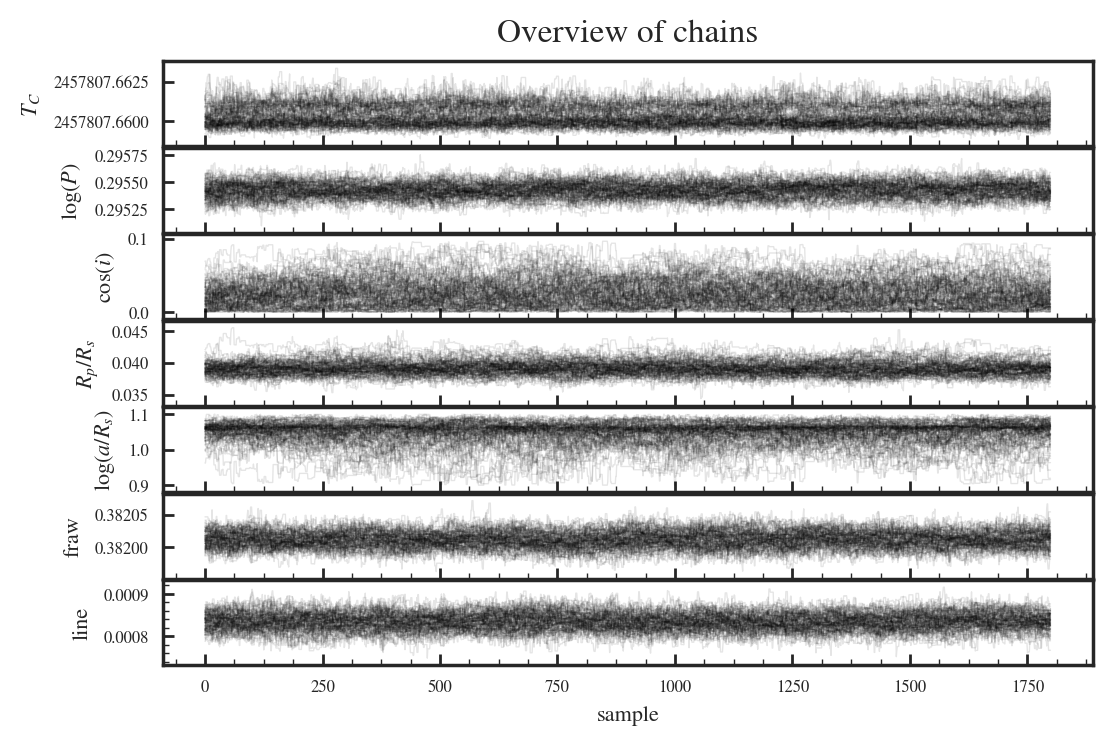

In [10]:
TF.plot_chains(burn=200)

In [11]:
TF.gelman_rubin(burn=200)

array([ 1.05103781,  1.03282079,  1.09018958,  1.06253918,  1.08426646,
        1.03325661,  1.04015141])

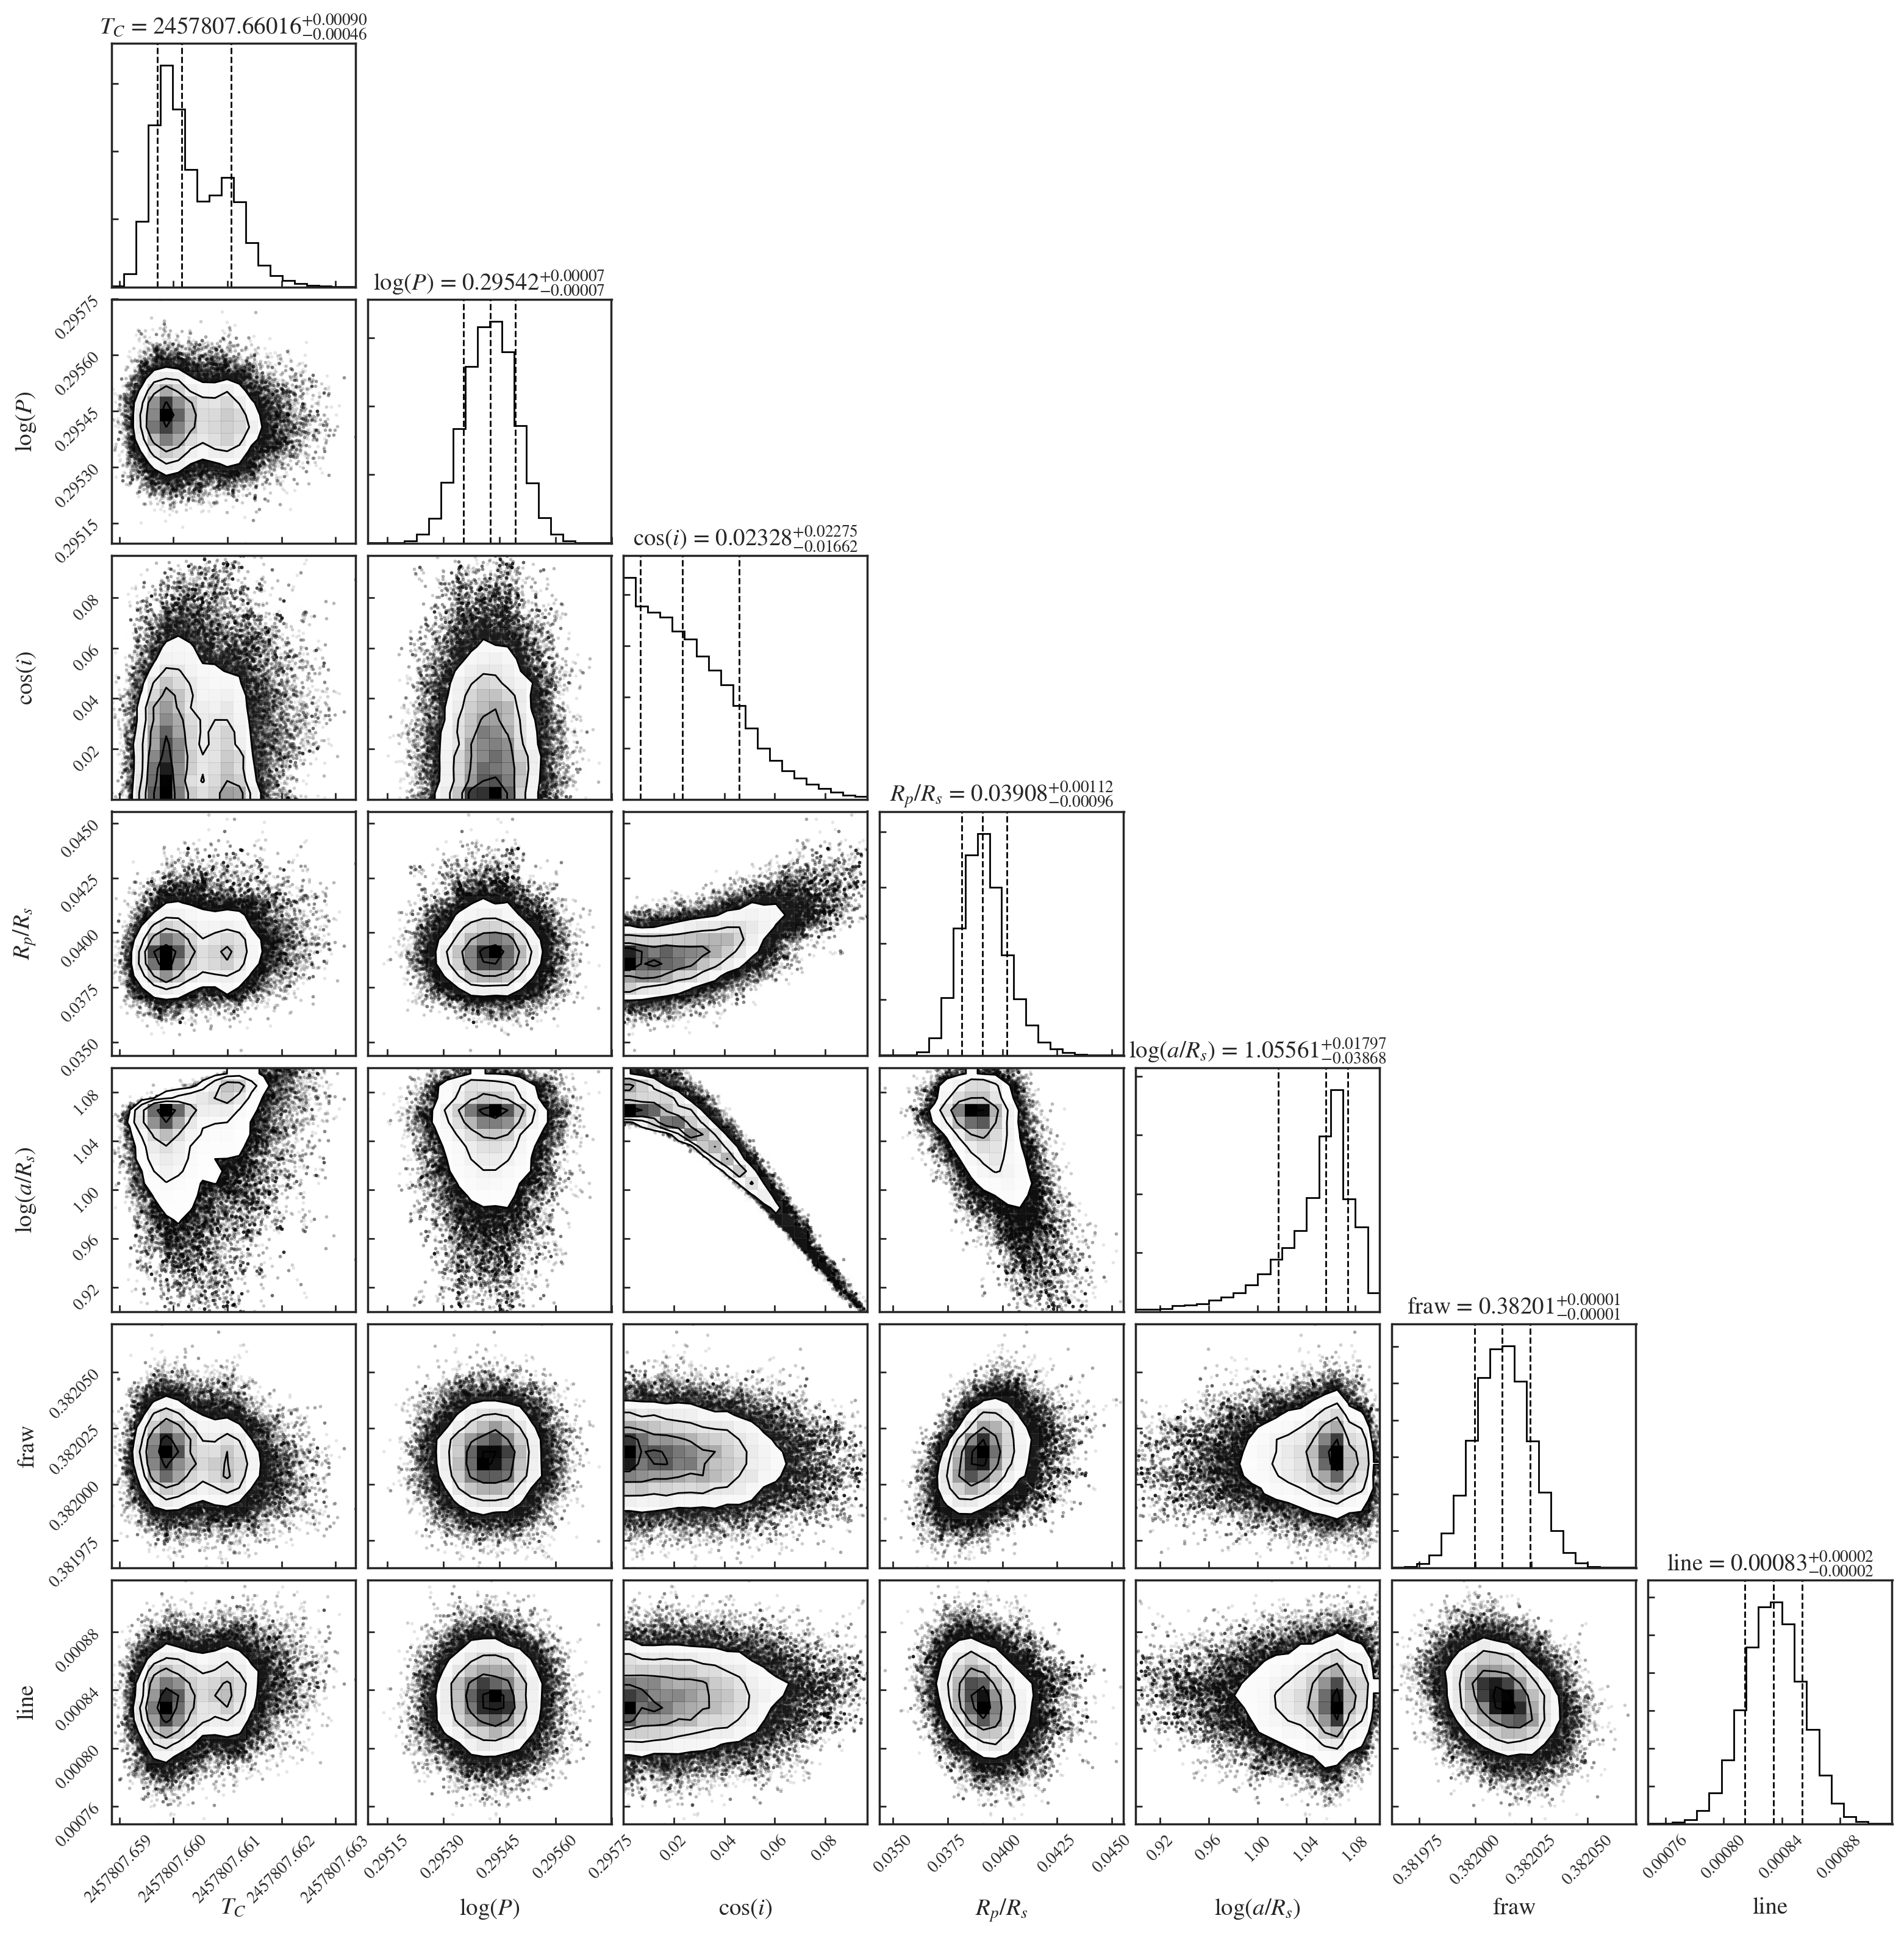

In [12]:
TF.plot_corner(show_titles=True,burn=200)

In [14]:
df_param = TF.get_transit_parameters(burn=200,
                                     thin=1,
                                     st_rad=0.288,
                                     st_raderr1=0.028,
                                     st_teff=3214.,
                                     st_teff_err1=60.,
                                     rho_instead_of_aRs=False)
df_param

Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3
0.295406727009
1.9742708217
ASSUMING aRs IS JUMP PARAMETER pv[4]
18


medvals      minus       plus                                 values  \
0   2.457808e+06   0.000456   0.000905  $2457807.66016_{-0.00046}^{+0.00090}$   
1   1.974352e+00   0.000321   0.000307        $1.97435_{-0.00032}^{+0.00031}$   
2   3.908426e-02   0.000956   0.001119         $0.03908_{-0.00096}^{+0.0011}$   
3   1.229067e+00   0.122329   0.124538                 $1.23_{-0.12}^{+0.12}$   
4   1.096502e-01   0.010913   0.011111               $0.11_{-0.011}^{+0.011}$   
5   1.527579e-03   0.000074   0.000089       $0.001528_{-0.00007}^{+0.00009}$   
6   1.136605e+01   0.968516   0.480252                $11.37_{-0.97}^{+0.48}$   
7   1.497141e-02   0.001817   0.001754            $0.015_{-0.0018}^{+0.0018}$   
8   7.125881e+00   1.670595   0.942229                  $7.13_{-1.7}^{+0.94}$   
9   8.866630e+01   1.304067   0.952366                 $88.67_{-1.3}^{+0.95}$   
10  2.654289e-01   0.187014   0.214314                 $0.27_{-0.19}^{+0.21}$   
11  0.000000e+00   0.000000   0.000000                    $0.0_{-0.0}^{+0.0}$   
12  0.000000e+00   0.000000   0.000000                    $0.0_{-0.0}^{+0.0}$   
13  4.735504e+02  14.383950  21.702397                $474.0_{-14.0}^{+22.0}$   
14  3.490057e+01   4.051060   6.851253                   $34.9_{-4.1}^{+6.9}$   
15  5.580339e-02   0.001968   0.000967          $0.0558_{-0.0020}^{+0.00097}$   
16  2.237802e-03   0.000167   0.000510        $0.00224_{-0.00017}^{+0.00051}$   
17  2.457809e+06   0.000500   0.000877  $2457808.64736_{-0.00050}^{+0.00088}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

In [22]:
# Calc phases
pv = TF.get_mean_values_mcmc_posteriors().medvals.values
pp  = df_param["medvals"][df_param["Description"]=="Orbital period"].values[0]
tt0  = df_param["medvals"][df_param["Description"]=="Transit Midpoint"].values[0]
phases_data = utils.get_phases(TF.lpf.data["time"],pp,tt0)
phases_fit = utils.get_phases(TF.lpf.data["time"],pp,tt0)
df_fold = pd.DataFrame(zip(phases_fit,TF.lpf.compute_lc_model(pv)),columns=["phase","model"]).sort_values("phase")

In [48]:
import plot_transits
scaled_flux = TF.lpf.data["flux"]/pv[TF.lpf.number_pv_baseline]
scaled_flux_no_trend = scaled_flux - TF.lpf.detrend(pv)
scaled_error = TF.lpf.data["error"]/pv[TF.lpf.number_pv_baseline]
residual= scaled_flux - TF.lpf.compute_lc_model(pv)

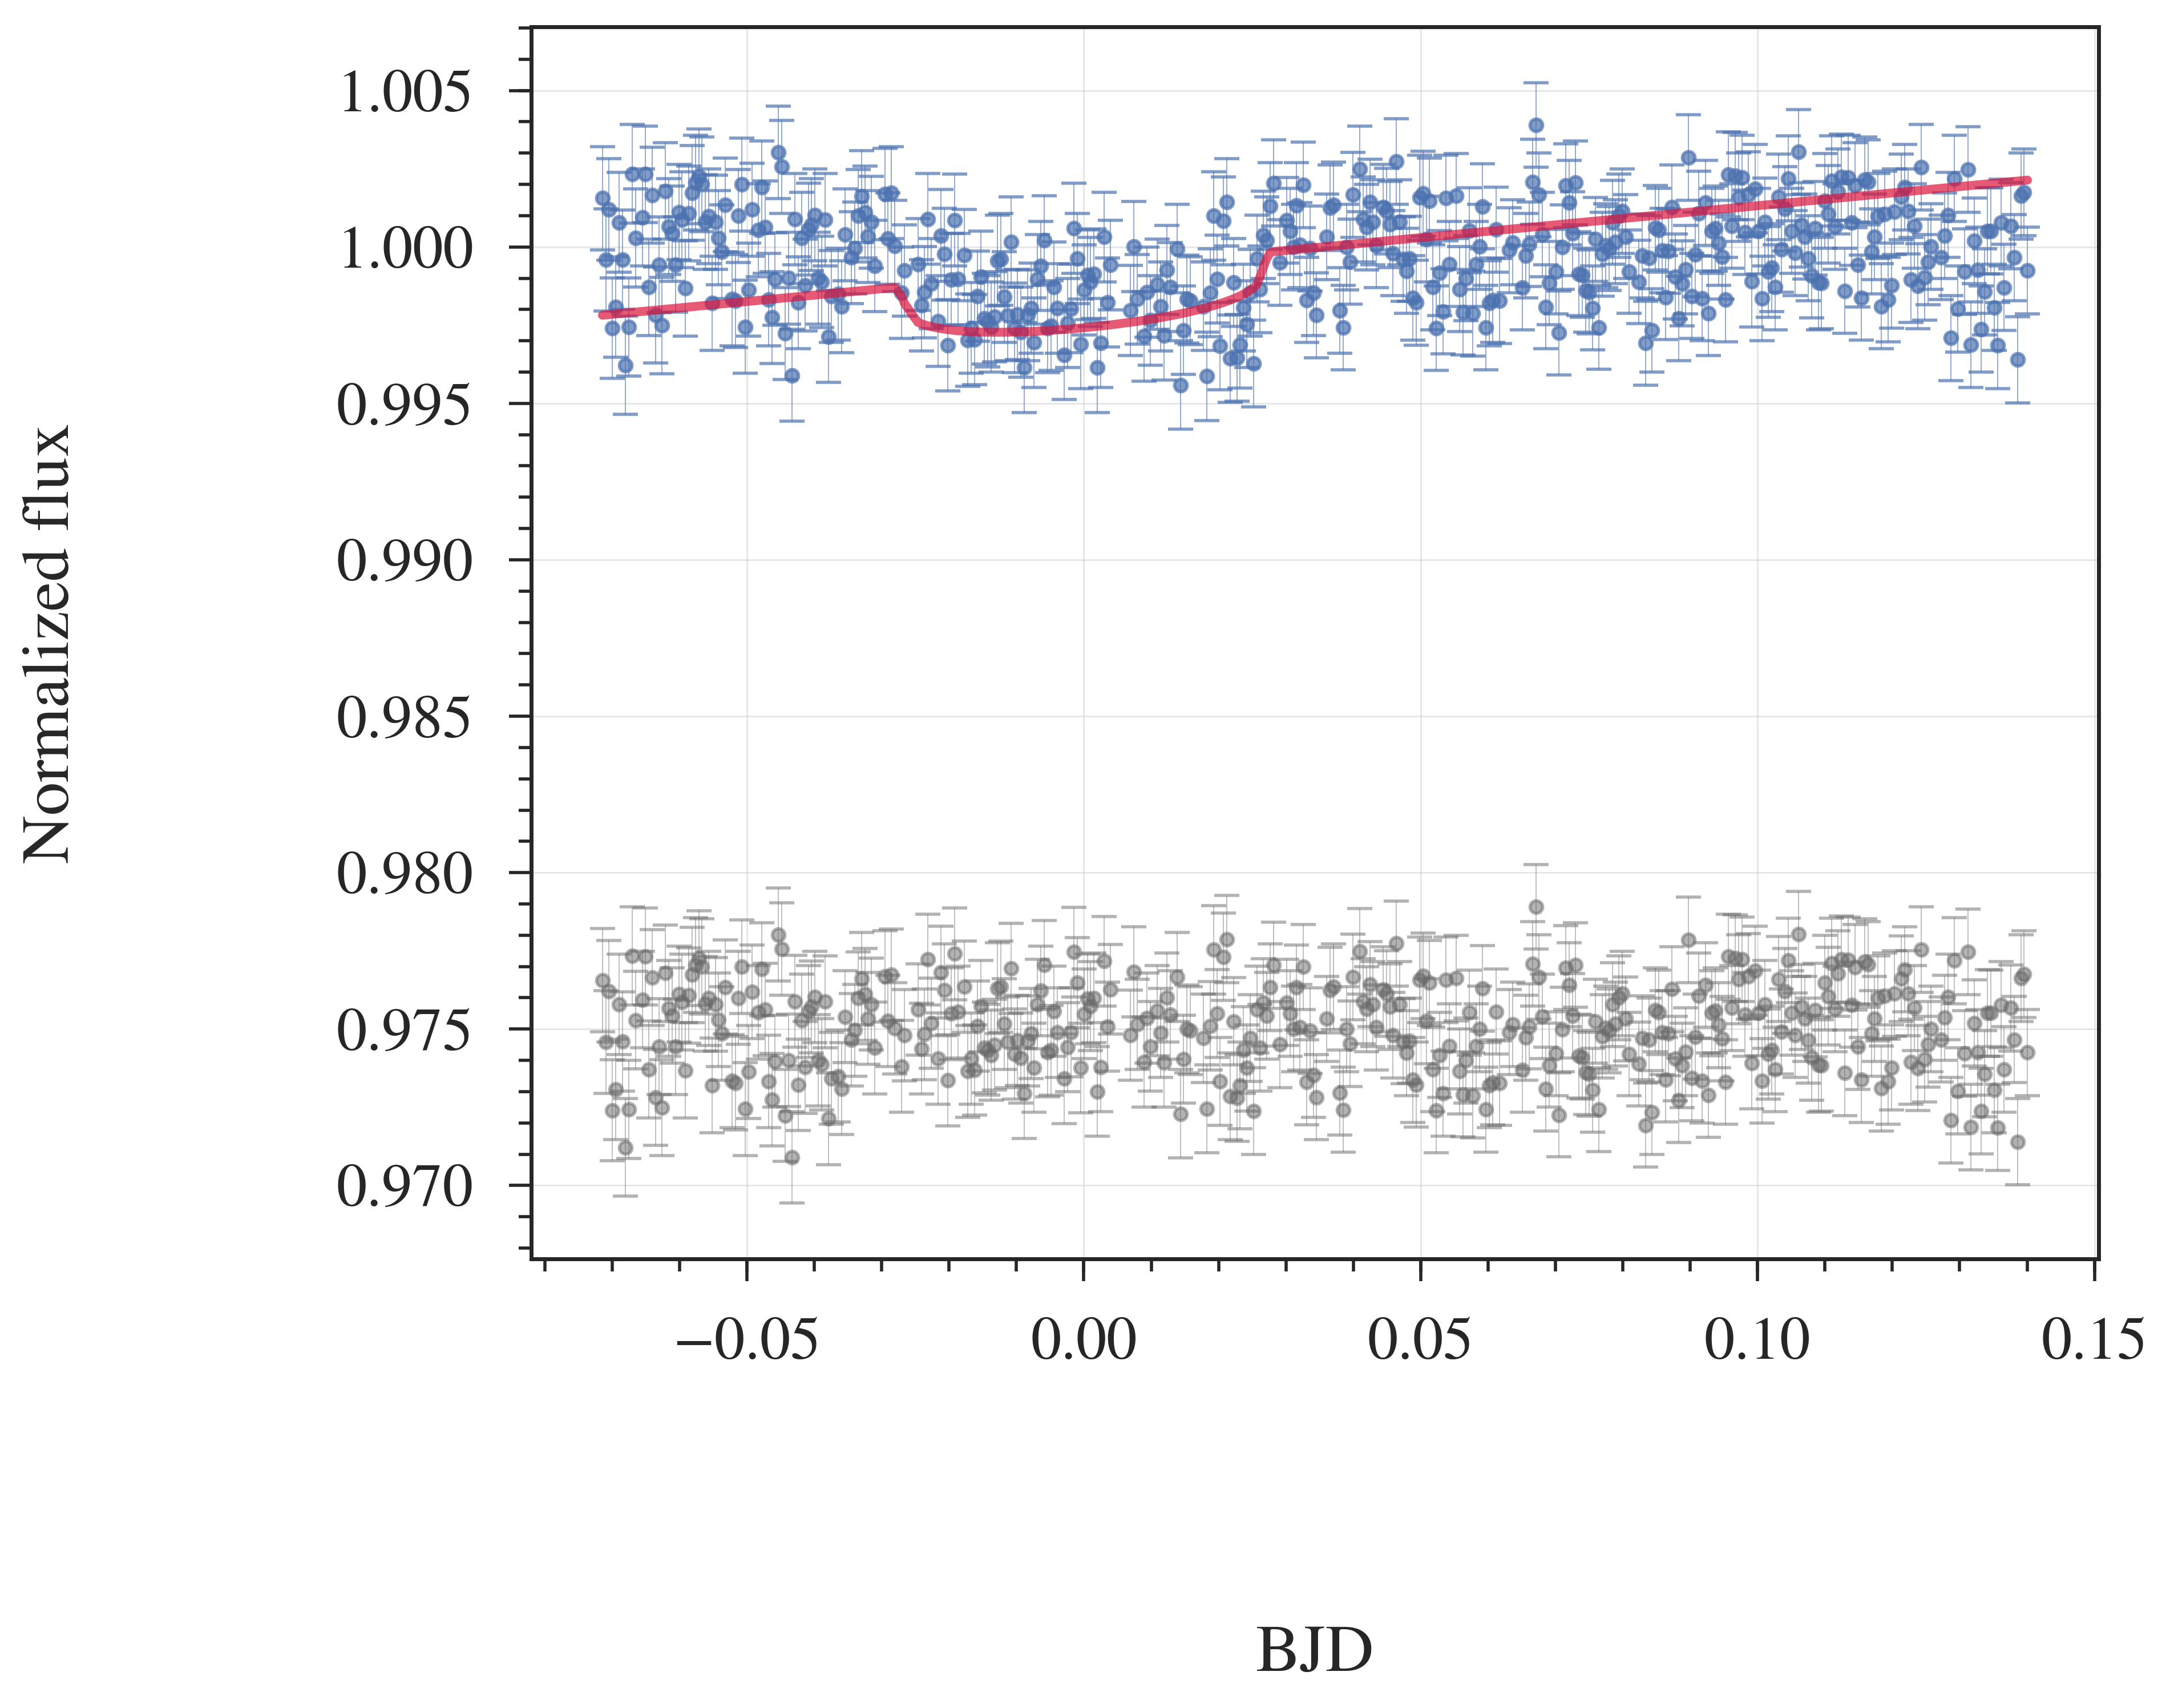

In [49]:
fig, ax = plt.subplots(figsize=(10,8),dpi=200)
plot_transits.plot_transit_with_model(phases_data*pp,
                                                 scaled_flux_no_trend,
                                                 scaled_error,
                                                 residual,
                                                 df_fold.phase*pp,
                                                 df_fold.model,ax=ax,offset=0.975)
fig.tight_layout()